In [2]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import openpyxl
import folium
import platform  
from shapely import wkt
from shapely.geometry import Point
from itertools import product
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression

In [3]:
#Read Machine name for automatic path definitions
machine_name = platform.node()

In [4]:
# Read MosquitoAlert data
if machine_name == 'DomTab':  
    Mos21_path = r"C:\Users\domik\ucloud\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\all_reports2021.json"
    Mos22_path = r"C:\Users\domik\ucloud\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\all_reports2022.json"
    Mos23_path = r"C:\Users\domik\ucloud\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\all_reports2023.json"
    Mos24_path = r"C:\Users\domik\ucloud\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\all_reports2024.json"
    
elif machine_name == 'DESKTOP-9E8GUN5':  
    Mos21_path = r"C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\all_reports2021.json"
    Mos22_path = r"C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\all_reports2022.json"
    Mos23_path = r"C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\all_reports2023.json"
    Mos24_path = r"C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\all_reports2024.json"
    
else:
    raise Exception("Unknown device")

Mos21 = pd.read_json(Mos21_path)
Mos22 = pd.read_json(Mos22_path)
Mos23 = pd.read_json(Mos23_path)
Mos24 = pd.read_json(Mos24_path)

In [5]:
#Merge dfs
Mos = pd.concat([Mos21, Mos22, Mos23, Mos24], ignore_index=True)
Mos.shape

(218277, 31)

In [6]:
# Check complext attribute "movelab_annotation_euro". It contains information about validation process
pd.set_option('display.max_colwidth', None)

non_null_entries = Mos['movelab_annotation_euro'].dropna().head(10)
print(non_null_entries)

1                                                                                                                                                                   {'edited_user_notes': 'De mug op deze foto lijkt niet op een van onze doelsoorten, het lijkt op een andere muggensoort. Op www.mosquitoalert.com vind u tips en tricks voor het vangen en fotograferen van deze insecten. Blijf alstublieft foto's insturen!', 'photo_html': '<a href="https://webserver.mosquitoalert.com/media/tigapics/72734f3d-d9bc-4367-a8ae-5a20356a3bbc.jpg" target="_blank"><img src="https://webserver.mosquitoalert.com/media/tigapics_popups/72734f3d-d9bc-4367-a8ae-5a20356a3bbc.jpg"></a>', 'class_name': 'Other species', 'class_label': 'other-species', 'class_id': 2, 'class_value': None}
2                                                                                                                                                                                                                                       

In [11]:
#Filter only Aedes albopictus data
def filter_albopictus(annotation):
    try:
        if annotation and isinstance(annotation, dict):
            return annotation.get('class_id') ==  4
    except:
        return False
    return False

# Apply function "filter_albopictus"
Mos_albo = Mos[Mos['movelab_annotation_euro'].apply(filter_albopictus)]

print(Mos_albo.head())

                            version_UUID                    creation_time  \
4   08a15465-3c28-401d-8eb8-d1d51d8946ab 2021-06-06 09:47:36.840475+00:00   
7   5307b82a-bce1-4aad-9a07-7c62ab2c53a3 2021-06-16 06:43:10.831268+00:00   
11  19d2b2eb-8408-417c-a175-d78941e1e569 2021-07-27 17:45:26.336946+00:00   
25  bb543cf0-faff-426a-904c-97792947ebc3 2021-10-20 13:24:53.865767+00:00   
44  481dd895-61dd-44d7-9ade-c711b623c0c4 2021-05-31 16:45:05.748251+00:00   

   creation_date  creation_day_since_launch  creation_year  creation_month  \
4     2021-06-06                       2550           2021               6   
7     2021-06-16                       2560           2021               6   
11    2021-07-27                       2601           2021               7   
25    2021-10-20                       2686           2021              10   
44    2021-05-31                       2544           2021               5   

    site_cat   type        lon        lat  ...  final_expert_status_

In [12]:
#Convert into GeoDataFrame and transform to crs=31287
Albo_gdf = gpd.GeoDataFrame(Mos_albo, geometry=gpd.points_from_xy(Mos_albo['lon'], Mos_albo['lat']))
print(Albo_gdf.head())
Albo_gdf.set_crs(epsg=4326, inplace=True)
Albo_gdf = Albo_gdf.to_crs(epsg=31287)
print(Albo_gdf.crs)

                            version_UUID                    creation_time  \
4   08a15465-3c28-401d-8eb8-d1d51d8946ab 2021-06-06 09:47:36.840475+00:00   
7   5307b82a-bce1-4aad-9a07-7c62ab2c53a3 2021-06-16 06:43:10.831268+00:00   
11  19d2b2eb-8408-417c-a175-d78941e1e569 2021-07-27 17:45:26.336946+00:00   
25  bb543cf0-faff-426a-904c-97792947ebc3 2021-10-20 13:24:53.865767+00:00   
44  481dd895-61dd-44d7-9ade-c711b623c0c4 2021-05-31 16:45:05.748251+00:00   

   creation_date  creation_day_since_launch  creation_year  creation_month  \
4     2021-06-06                       2550           2021               6   
7     2021-06-16                       2560           2021               6   
11    2021-07-27                       2601           2021               7   
25    2021-10-20                       2686           2021              10   
44    2021-05-31                       2544           2021               5   

    site_cat   type        lon        lat  ...  \
4          5  adul

In [13]:
#Read Graz city boundaries
if machine_name == 'DomTab':  
   boundaries_path = r"C:\Users\domik\ucloud\Mein_Studium\Masterarbeit\Jupyter\Data\QGIS\Stadtgrenze\Stadtgrenze_31287.shp"
       
elif machine_name == 'DESKTOP-9E8GUN5': 
    boundaries_path = r"C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\QGIS\Stadtgrenze\Stadtgrenze_31287.shp"
    
    
else:
    raise Exception("Unknown device")

boundaries = gpd.read_file(boundaries_path)

pd.reset_option('display.max_colwidth')
print(boundaries.head())
print(boundaries.crs)

  GEMEINDE         area                                           geometry
0     Graz  127562648.9  POLYGON ((556913.451 361501.126, 556927.473 36...
EPSG:31287


In [14]:
# Perform spatial join to keep only points within the city of Graz
Albo_graz_gdf = gpd.sjoin(Albo_gdf, boundaries, predicate='within')

print(Albo_graz_gdf)

                                version_UUID                    creation_time  \
12783   9a493757-6cd4-408b-8ead-aa9d1f49d78a 2021-07-05 17:13:01.367651+00:00   
30797   e92d7502-77e9-44e8-a10c-69032318d1e4 2021-08-10 16:35:22.540217+00:00   
31120   115b6213-b88a-437a-84d1-5f60b8d61425 2021-08-14 11:09:37.774025+00:00   
31805   74271c41-8ba2-4cd2-b240-abc23c698eec 2021-08-14 14:51:27.047366+00:00   
31971   87cbc13f-2ff3-406f-920f-e1fa344d73c8 2021-08-14 11:03:44.228567+00:00   
...                                      ...                              ...   
218034  8c4ed54f-d333-4fe3-b201-b873d8dbbc2f 2024-07-24 17:56:18.497117+00:00   
218071  423793b2-b392-4e8f-818f-9e790744e228 2024-08-09 08:27:47.806980+00:00   
218132  9a2dc760-b714-4ce9-8ed6-8a6828f6f907 2024-08-27 17:01:23.820154+00:00   
218161  faf059d3-4467-4f95-8c8b-d8242c4e2128 2024-09-08 19:14:16.893954+00:00   
218248  4d571024-0ba0-4bc3-b683-641112b4fdcb 2024-11-14 07:41:04.819214+00:00   

       creation_date  creat

In [15]:
#Filter only sightings (remove bites, breeding sites, etc.)
Albo_graz_gdf=Albo_graz_gdf[Albo_graz_gdf['type']=='adult']
print(Albo_graz_gdf)

                                version_UUID                    creation_time  \
12783   9a493757-6cd4-408b-8ead-aa9d1f49d78a 2021-07-05 17:13:01.367651+00:00   
30797   e92d7502-77e9-44e8-a10c-69032318d1e4 2021-08-10 16:35:22.540217+00:00   
31120   115b6213-b88a-437a-84d1-5f60b8d61425 2021-08-14 11:09:37.774025+00:00   
31805   74271c41-8ba2-4cd2-b240-abc23c698eec 2021-08-14 14:51:27.047366+00:00   
31971   87cbc13f-2ff3-406f-920f-e1fa344d73c8 2021-08-14 11:03:44.228567+00:00   
...                                      ...                              ...   
218034  8c4ed54f-d333-4fe3-b201-b873d8dbbc2f 2024-07-24 17:56:18.497117+00:00   
218071  423793b2-b392-4e8f-818f-9e790744e228 2024-08-09 08:27:47.806980+00:00   
218132  9a2dc760-b714-4ce9-8ed6-8a6828f6f907 2024-08-27 17:01:23.820154+00:00   
218161  faf059d3-4467-4f95-8c8b-d8242c4e2128 2024-09-08 19:14:16.893954+00:00   
218248  4d571024-0ba0-4bc3-b683-641112b4fdcb 2024-11-14 07:41:04.819214+00:00   

       creation_date  creat

### Filter for Validations Scores

In [16]:
# Store tiger_certainty_category in a new attribute. It is originaly stored in dictionary "movelab_annotation"
Albo_graz_gdf['tiger_certainty_category'] = Albo_graz_gdf['movelab_annotation'].apply(
    lambda x: x.get('tiger_certainty_category') if isinstance(x, dict) else None
)

Albo_graz_gdf['tiger_certainty_category'] = pd.to_numeric(
    Albo_graz_gdf['tiger_certainty_category'], errors='coerce'
)

# Filter for scores = 1 and 2
Albo_graz_gdf = Albo_graz_gdf[Albo_graz_gdf['tiger_certainty_category'] > 0]
Albo_graz_gdf_val2 = Albo_graz_gdf[Albo_graz_gdf['tiger_certainty_category'] > 1]

print(Albo_graz_gdf)

                                version_UUID                    creation_time  \
12783   9a493757-6cd4-408b-8ead-aa9d1f49d78a 2021-07-05 17:13:01.367651+00:00   
30797   e92d7502-77e9-44e8-a10c-69032318d1e4 2021-08-10 16:35:22.540217+00:00   
31120   115b6213-b88a-437a-84d1-5f60b8d61425 2021-08-14 11:09:37.774025+00:00   
31805   74271c41-8ba2-4cd2-b240-abc23c698eec 2021-08-14 14:51:27.047366+00:00   
31971   87cbc13f-2ff3-406f-920f-e1fa344d73c8 2021-08-14 11:03:44.228567+00:00   
...                                      ...                              ...   
218034  8c4ed54f-d333-4fe3-b201-b873d8dbbc2f 2024-07-24 17:56:18.497117+00:00   
218071  423793b2-b392-4e8f-818f-9e790744e228 2024-08-09 08:27:47.806980+00:00   
218132  9a2dc760-b714-4ce9-8ed6-8a6828f6f907 2024-08-27 17:01:23.820154+00:00   
218161  faf059d3-4467-4f95-8c8b-d8242c4e2128 2024-09-08 19:14:16.893954+00:00   
218248  4d571024-0ba0-4bc3-b683-641112b4fdcb 2024-11-14 07:41:04.819214+00:00   

       creation_date  creat

Sampling Effort data

Attribute description:

n_participants=         "Number of unique participants recorded in this cell on the given date. (Note that not all participants who pass through the  
                        cell are recorded: some may have opted out of background tracking; others may simply not have generated a background track 
                        taken while in the cell.)"
                        
SE_expected=           "Sampling effort estimated as the expected number of participants sending at least one report from the cell during the day in   
                        question given the the number of participants recorded in the cell that day and the amount of time elapsed since each one began 
                        participating in the project."
                        
SE=                     "Sampling effort estimated as the probability of at least one report being sent from the cell during the day in question given 
                        the number of participants recorded in the cell that day and the amount of time elapsed since each one began participating in  
                        the project."
                        
n_reports_albopictus=   "Number of validated reports of Ae. albopictus recorded in the cell that day. Validated defined here as having been given a 
                        score of 1 or 2 by the Mosquito Alert Digital Entolab."
                        
n_reports_bite=         "Number of bite reports recorded in the cell that day. Note that there is no validation of bite reports. For purpose of this 
                         variable, each report is counted as 1, regardless of the number of bites the participant indicates in the report."
                         
n_reporters_albopictus= "Number of unique participants who from whom at least one validated report of Ae. albopictus was recorded in the cell that day. 
                         Validated defined here as having been given a score of 1 or 2 by the Mosquito Alert Digital Entolab. Each participant sending 
                         at least one validated report is counted only once, no matter how many reports they sent."
                         
n_reporters_bite=        Number of unique participants who from whom at least one bite report was recorded in the cell that day. Note that there is no 
                         validation of bite reports. Each participant sending at least one bite report is counted only once, no matter how many reports 
                         they sent (or how many bites they listed in each report).",


In [17]:
#Load Sampling Effort
if machine_name == 'DomTab':  
   SE_path = r"C:\Users\domik\ucloud\Mein_Studium\Masterarbeit\Jupyter\Data\Sampling Effort\sampling_effort_daily_cellres_025.csv"
       
elif machine_name == 'DESKTOP-9E8GUN5': 
    SE_path = r"C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\Sampling Effort\sampling_effort_daily_cellres_025.csv"
    
    
else:
    raise Exception("Unknown device")
SE=pd.read_csv(SE_path)
print(SE.head(100))


     TigacellID        date  n_participants  SE_expected        SE  \
0   -0.025_-0.1  2024-10-08               1     0.101741  0.101741   
1   -0.025_-1.1  2024-08-01               1     0.101741  0.101741   
2   -0.025_0.05  2024-06-22               1     0.101741  0.101741   
3    -0.025_0.2  2024-06-25               1     0.019044  0.019044   
4   -0.025_38.6  2015-08-28               1     0.011477  0.011477   
..          ...         ...             ...          ...       ...   
95    -0.025_40  2023-06-12               1     0.101741  0.101741   
96    -0.025_40  2023-06-13               1     0.013529  0.013529   
97    -0.025_40  2023-06-25               2     0.203482  0.193131   
98    -0.025_40  2024-07-03               1     0.002815  0.002815   
99    -0.025_40  2024-07-10               1     0.002678  0.002678   

    masked_lon  masked_lat  n_reports_bite  n_reports_albopictus  \
0       -0.025       -0.10               1                     0   
1       -0.025       -1

In [18]:
#Remove entries from 2020 and earlier
SE['date']=pd.to_datetime(SE['date'])
SE=SE[SE['date'].dt.year>2020]
print(SE.head())
SE.shape

      TigacellID       date  n_participants  SE_expected        SE  \
0    -0.025_-0.1 2024-10-08               1     0.101741  0.101741   
1    -0.025_-1.1 2024-08-01               1     0.101741  0.101741   
2    -0.025_0.05 2024-06-22               1     0.101741  0.101741   
3     -0.025_0.2 2024-06-25               1     0.019044  0.019044   
8  -0.025_38.625 2021-09-20               1     0.019044  0.019044   

   masked_lon  masked_lat  n_reports_bite  n_reports_albopictus  \
0      -0.025      -0.100               1                     0   
1      -0.025      -1.100               1                     0   
2      -0.025       0.050               1                     0   
3      -0.025       0.200               1                     0   
8      -0.025      38.625               1                     0   

   n_reports_culex  n_reports_japonicus  n_reports_aegypti  \
0                0                    0                  0   
1                0                    0             

(417308, 19)

In [19]:
#Load ovitrap data
if machine_name == 'DomTab':  
   OT_path = r"C:\Users\domik\ucloud\Mein_Studium\Masterarbeit\Jupyter\Data\Ovitrap\Ovitrap_Stmk_Ae.albopictus_2020-2024_20250122.xlsx"
       
elif machine_name == 'DESKTOP-9E8GUN5': 
    OT_path = r"C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\Ovitrap\Ovitrap_Stmk_Ae.albopictus_2020-2024_20250122.xlsx"
    
    
else:
    raise Exception("Unknown device")

OT=pd.read_excel(OT_path,engine='openpyxl')
print(OT)
OT_gdf=gpd.GeoDataFrame(OT,geometry=gpd.points_from_xy(OT['Longitude'], OT['Latitude']))
OT_gdf = OT_gdf.set_crs(epsg=4326, inplace=True)

                ID_Catch Position   Latitude  Longitude  Altitude Site  \
0     OT_AGG_01_20210429   AGG_01  47.075658  15.450629       394  AGG   
1     OT_AGG_01_20210505   AGG_01  47.075658  15.450629       394  AGG   
2     OT_AGG_01_20210512   AGG_01  47.075658  15.450629       394  AGG   
3     OT_AGG_01_20210519   AGG_01  47.075658  15.450629       394  AGG   
4     OT_AGG_01_20210526   AGG_01  47.075658  15.450629       394  AGG   
...                  ...      ...        ...        ...       ...  ...   
3411  OT_LBZ_05_20240925   LBZ_05  46.777130  15.557460       266  LBZ   
3412  OT_LBZ_05_20241002   LBZ_05  46.777130  15.557460       266  LBZ   
3413  OT_LBZ_05_20241009   LBZ_05  46.777130  15.557460       266  LBZ   
3414  OT_LBZ_05_20241016   LBZ_05  46.777130  15.557460       266  LBZ   
3415  OT_LBZ_05_20241023   LBZ_05  46.777130  15.557460       266  LBZ   

      Site_name  Country    Province     District                 CLC_Level_3  \
0     AGES Graz  Austria  Stei

In [20]:
#Reproject layers for plotting
Albo_graz_gdf=Albo_graz_gdf.to_crs(epsg=4326)
boundaries=boundaries.to_crs(epsg=4326)

In [21]:
#Select relevant SE grid cells: lower-left (46.875, 15.025) and upper-right (47.325, 15.750)
#prepare data to plot SE_grid
lower_left = (46.875, 15.025)  
upper_right = (47.325, 15.750)
cell_size = 0.025  # According to SE data

# function to generate grid points
def gen_grid(start, stop, step):
    while start < stop:
        yield round(start, 5)  # rounding to handle precision issuesof floating points
        start += step

# Generate  SE cells for plotting
lat_values = list(
    gen_grid(lower_left[0], upper_right[0], cell_size)
)
lon_values = list(
    gen_grid(lower_left[1], upper_right[1], cell_size)
)

In [22]:
#Plot NUTS, Mos, OT
m = folium.Map(location=[47.05, 15.45], zoom_start=10, control_scale=True)
folium.GeoJson(boundaries).add_to(m)

# Mosquito sightings
for _, row in Albo_graz_gdf.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),  
        radius=0.3,  
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
            ).add_to(m)

# ovitrap locations
for _, row in OT_gdf.iterrows():
    folium.Marker(
        location=(row.geometry.y, row.geometry.x),
        icon=folium.DivIcon(
            html='<div style="font-size: 14px; color: green;">&#9650;</div>',  
        ),
        # Popup option with location info
        popup=folium.Popup(html=f'<b>Info:</b> {row["Position"]}', max_width=300)
    ).add_to(m)

#SE grid
for lat in lat_values:
    for lon in lon_values:
        folium.Rectangle(
            bounds=[
                (lat, lon),  # lower-left corner
                (lat + cell_size, lon + cell_size)  # upper-right corner
            ],
            color='black',
            fill=False,
            weight=0.2
        ).add_to(m)
    
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 150px; height: auto; 
            z-index: 9999; font-size:11px;
            background-color: white;
            border: 2px solid gray;
            padding: 10px;
            ">
&nbsp; <b>Legend</b> <br>
&nbsp; <i style="color:red;">&#9679;</i>&nbsp; Mosquito Reports <br>
&nbsp; <i style="color:green;">&#9650;</i>&nbsp; Ovitrap Locations <br>
&nbsp; <i style="border-top: 2px solid blue; width: 20px; display: inline-block; height: 0;"></i>&nbsp; Nuts3 Graz <br>
&nbsp; <i style="color:black; border: 1px solid black; width: 20px; display: inline-block; height: 0;"></i>&nbsp; SE Grid <br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50%; transform: translateX(-50%);
            z-index: 9999; font-size: 14px; color: black; 
            background: white; padding: 10px; border: 2px solid gray;
            border-radius: 5px;">
    <b>Mosquito sightings, ovitrap locations, SE cells, NUTS3 Graz</b>
</div>
'''

m.get_root().html.add_child(folium.Element(title_html))

m

## Monthly sums of Mosquito sightings

In [23]:
print(Albo_graz_gdf.columns)

Index(['version_UUID', 'creation_time', 'creation_date',
       'creation_day_since_launch', 'creation_year', 'creation_month',
       'site_cat', 'type', 'lon', 'lat', 'location_is_masked',
       'movelab_annotation', 'movelab_annotation_euro', 'tiger_responses',
       'tiger_responses_text', 'site_responses', 'site_responses_text',
       'tigaprob_cat', 'latest_version', 'visible', 'n_photos',
       'final_expert_status_text', 'responses', 'country', 'updated_at',
       'datetime_fix_offset', 'point', 'nuts_2', 'nuts_3', 'cached_visible',
       'session', 'geometry', 'index_right', 'GEMEINDE', 'area',
       'tiger_certainty_category'],
      dtype='object')


In [24]:
#Prepare data for temporal aggregation
Albo_graz_gdf['creation_date']=pd.to_datetime(Albo_graz_gdf['creation_date'])
#set creation_date as index for groupby()
Albo_graz_gdf['creation_date_backup'] = Albo_graz_gdf['creation_date']
Albo_graz_gdf.set_index('creation_date', inplace=True)

In [25]:
monthly_range = pd.date_range(start='2021-01-01', end='2024-12-31', freq='ME')

# Aggregate data into monthly intervals
Albo_monthly_counts = Albo_graz_gdf.resample('ME').size()

# Add entries for months with no sightings for a continuous time series
Albo_monthly_counts = Albo_monthly_counts.reindex(monthly_range, fill_value=0)
print(Albo_monthly_counts)

2021-01-31      0
2021-02-28      0
2021-03-31      0
2021-04-30      0
2021-05-31      0
2021-06-30      0
2021-07-31      1
2021-08-31      7
2021-09-30      4
2021-10-31      1
2021-11-30      0
2021-12-31      0
2022-01-31      0
2022-02-28      0
2022-03-31      0
2022-04-30      0
2022-05-31      0
2022-06-30      1
2022-07-31      4
2022-08-31     57
2022-09-30     34
2022-10-31      8
2022-11-30      0
2022-12-31      0
2023-01-31      0
2023-02-28      0
2023-03-31      0
2023-04-30      0
2023-05-31      2
2023-06-30     12
2023-07-31     54
2023-08-31     57
2023-09-30    122
2023-10-31     50
2023-11-30      4
2023-12-31      0
2024-01-31      0
2024-02-29      0
2024-03-31      2
2024-04-30      1
2024-05-31      5
2024-06-30     62
2024-07-31    140
2024-08-31    306
2024-09-30    157
2024-10-31     20
2024-11-30      3
2024-12-31      1
Freq: ME, dtype: int64


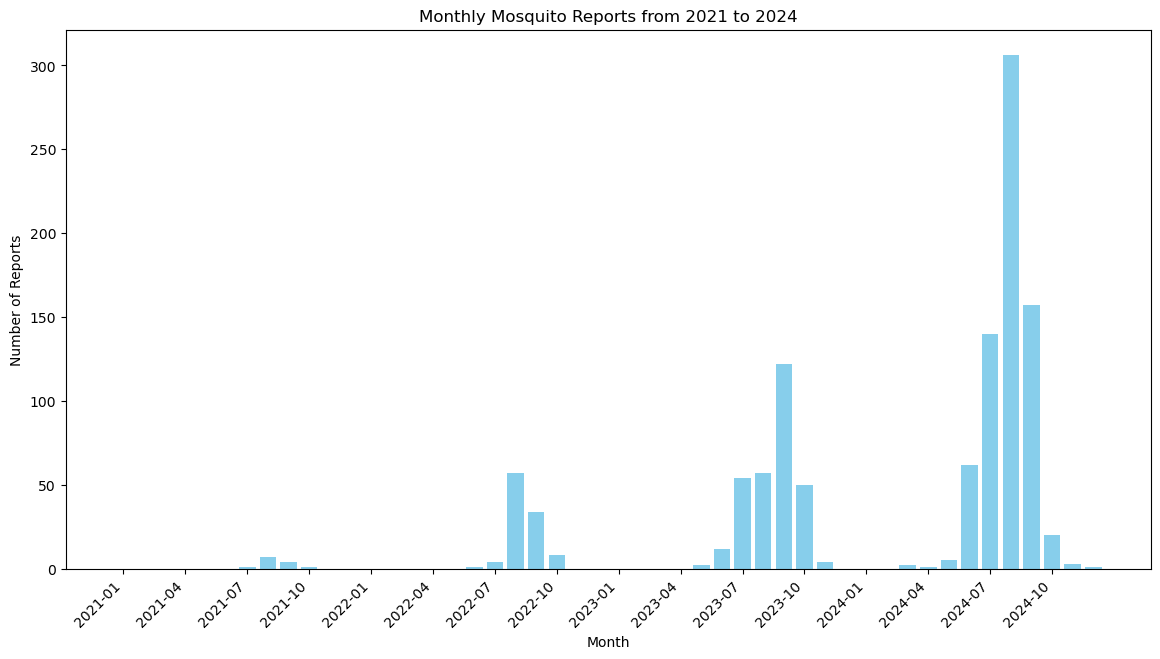

In [26]:
# Plot histogram of monthly sums of mosquito sightings
plt.figure(figsize=(14, 7))
plt.bar(Albo_monthly_counts.index.strftime('%Y-%m'), Albo_monthly_counts, color='skyblue', width=0.8)

plt.title('Monthly Mosquito Reports from 2021 to 2024')
plt.xlabel('Month')
plt.ylabel('Number of Reports')

# Set x-tick labels
quarterly_labels = Albo_monthly_counts.index[::3] 
plt.xticks(ticks=range(0, len(Albo_monthly_counts), 3), labels=quarterly_labels.strftime('%Y-%m'), rotation=45, ha='right')

plt.show()


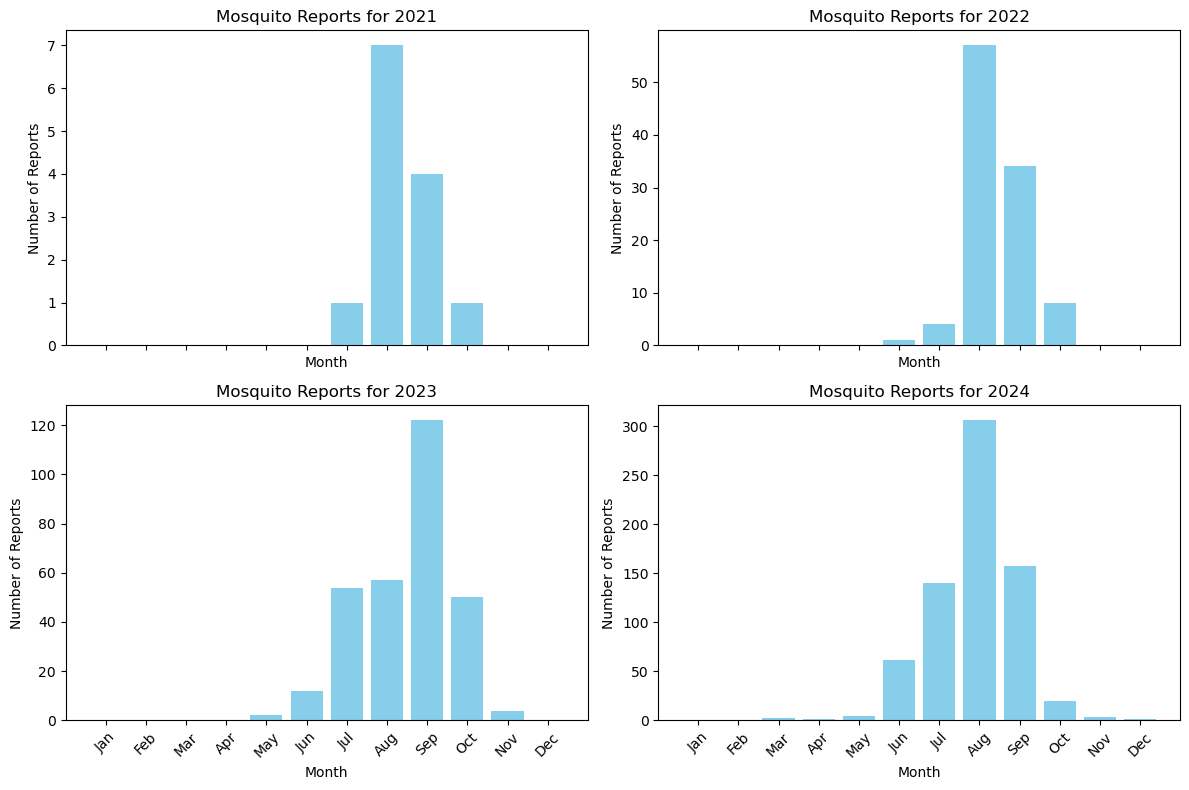

In [27]:
# Plot 2021-2024 individually
# Extract unique years from the data
unique_years = Albo_monthly_counts.index.year.unique()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

# loop through years and create individual subplots
for i, year in enumerate(unique_years):
    year_data = Albo_monthly_counts[Albo_monthly_counts.index.year == year]
    
    axes[i].bar(year_data.index.strftime('%b'), year_data, color='skyblue')
    axes[i].set_title(f'Mosquito Reports for {year}')
    axes[i].set_ylabel('Number of Reports')

    axes[i].set_xticks(range(len(year_data)))
    axes[i].set_xticklabels(year_data.index.strftime('%b'), rotation=45, ha='center')

for i in axes:
    i.set_xlabel('Month') 
    
plt.tight_layout()
plt.show()

# SE Editing

In [28]:
print(SE.head())

      TigacellID       date  n_participants  SE_expected        SE  \
0    -0.025_-0.1 2024-10-08               1     0.101741  0.101741   
1    -0.025_-1.1 2024-08-01               1     0.101741  0.101741   
2    -0.025_0.05 2024-06-22               1     0.101741  0.101741   
3     -0.025_0.2 2024-06-25               1     0.019044  0.019044   
8  -0.025_38.625 2021-09-20               1     0.019044  0.019044   

   masked_lon  masked_lat  n_reports_bite  n_reports_albopictus  \
0      -0.025      -0.100               1                     0   
1      -0.025      -1.100               1                     0   
2      -0.025       0.050               1                     0   
3      -0.025       0.200               1                     0   
8      -0.025      38.625               1                     0   

   n_reports_culex  n_reports_japonicus  n_reports_aegypti  \
0                0                    0                  0   
1                0                    0             

## Crop extent to Graz and add entries for every day and every cell

In [29]:
SE['date'] = pd.to_datetime(SE['date'])

# Crop SE to Graz extent
lower_left = (47, 15.325)  
upper_right = (47.125, 15.55)

SE_cropped = SE[
    (SE['masked_lat'] >= lower_left[0]) & (SE['masked_lat'] <= upper_right[0]) &
    (SE['masked_lon'] >= lower_left[1]) & (SE['masked_lon'] <= upper_right[1])
].copy()

# Create date range for the entire time span in days (SE is collected on daily basis)
daily_range = pd.date_range(start='2021-01-01', end='2024-12-31', freq='D')

#unique masked lat/lon combinations to identify SE cells
unique_cells = SE_cropped[['masked_lat', 'masked_lon']].drop_duplicates()

# Initialize a list that will contain all SE entries for each cell and day (including SE=0 that were missing in original SE data)
complete_entries = []

#loop through each unique cell and create entries for each day in the date range
for _, cell in unique_cells.iterrows():
    for day in daily_range:
        # check if entries exist for the specific cell and day
        cell_entries = SE_cropped[
            (SE_cropped['masked_lat'] == cell['masked_lat']) & 
            (SE_cropped['masked_lon'] == cell['masked_lon']) & 
            (SE_cropped['date'] == day)
        ]
        
        if not cell_entries.empty:
            # If an entry exists for that cell and that day, original SE attribute values are stored in complete_entries
            for _, entry in cell_entries.iterrows():
                complete_entries.append({
                    'masked_lat': cell['masked_lat'],
                    'masked_lon': cell['masked_lon'],
                    'date': entry['date'],
                    'n_participants': entry['n_participants'],  # Keep original values
                    'SE_expected': entry['SE_expected'],
                    'SE': entry['SE'],
                    'n_reports_albopictus': entry['n_reports_albopictus'],
                    'n_reports_bite': entry['n_reports_bite'],
                    'n_reports_culex': entry['n_reports_culex'],
                    'n_reports_japonicus': entry['n_reports_japonicus'],
                    'n_reports_aegypti': entry['n_reports_aegypti'],
                    'n_reports_koreicus': entry['n_reports_koreicus'],
                    'n_reporters_albopictus': entry['n_reporters_albopictus'],
                    'n_reporters_bite': entry['n_reporters_bite'],
                    'n_reporters_culex': entry['n_reporters_culex'],
                    'n_reporters_japonicus': entry['n_reporters_japonicus'],
                    'n_reporters_aegypti': entry['n_reporters_aegypti'],
                    'n_reporters_koreicus': entry['n_reporters_koreicus']
                })
        else:
            # If no entry for given day and ceell, create a new entry with SE and other values set to 0
            complete_entries.append({
                'masked_lat': cell['masked_lat'],
                'masked_lon': cell['masked_lon'],
                'date': day,
                'n_participants': 0,
                'SE_expected': 0,
                'SE': 0,
                'n_reports_albopictus': 0,
                'n_reports_bite': 0,
                'n_reports_culex': 0,
                'n_reports_japonicus': 0,
                'n_reports_aegypti': 0,
                'n_reports_koreicus': 0,
                'n_reporters_albopictus': 0,
                'n_reporters_bite': 0,
                'n_reporters_culex': 0,
                'n_reporters_japonicus': 0,
                'n_reporters_aegypti': 0,
                'n_reporters_koreicus': 0
            })

# Create final df from complete_entries
SE_cropped_complete = pd.DataFrame(complete_entries)

In [30]:
print(SE_cropped_complete)

       masked_lat  masked_lon       date  n_participants  SE_expected   SE  \
0            47.0      15.325 2021-01-01               0          0.0  0.0   
1            47.0      15.325 2021-01-02               0          0.0  0.0   
2            47.0      15.325 2021-01-03               0          0.0  0.0   
3            47.0      15.325 2021-01-04               0          0.0  0.0   
4            47.0      15.325 2021-01-05               0          0.0  0.0   
...           ...         ...        ...             ...          ...  ...   
81811        47.1      15.500 2024-12-27               0          0.0  0.0   
81812        47.1      15.500 2024-12-28               0          0.0  0.0   
81813        47.1      15.500 2024-12-29               0          0.0  0.0   
81814        47.1      15.500 2024-12-30               0          0.0  0.0   
81815        47.1      15.500 2024-12-31               0          0.0  0.0   

       n_reports_albopictus  n_reports_bite  n_reports_culex  \

# For Validation, show every entry for cell 47.05, 15.45 in August 2024

In [31]:
SE_cropped_complete.reset_index(inplace=True)

target_lat = 47.050  
target_lon = 15.450  

start_date = '2024-08-01'
end_date = '2024-08-31'

SE_validation = SE_cropped_complete[
    (SE_cropped_complete['masked_lat'] == target_lat) &
    (SE_cropped_complete['masked_lon'] == target_lon) &
    (SE_cropped_complete['date'] >= start_date) &
    (SE_cropped_complete['date'] <= end_date)
]

print(SE_validation.head())

       index  masked_lat  masked_lon       date  n_participants  SE_expected  \
29067  29067       47.05       15.45 2024-08-01               4     0.230118   
29068  29068       47.05       15.45 2024-08-02               1     0.101741   
29069  29069       47.05       15.45 2024-08-03               3     0.123909   
29070  29070       47.05       15.45 2024-08-04               2     0.203482   
29071  29071       47.05       15.45 2024-08-05               5     0.210316   

             SE  n_reports_albopictus  n_reports_bite  n_reports_culex  \
29067  0.214506                     1               0                0   
29068  0.101741                     0               0                0   
29069  0.121543                     0               3                0   
29070  0.193131                     1               1                0   
29071  0.198633                     4               5                0   

       n_reports_japonicus  n_reports_aegypti  n_reports_koreicus  \
29067

# Calculate monthly SE, SE_exp, N_participants for plotting

In [32]:
SE_cropped_complete['year_month'] = SE_cropped_complete['date'].dt.to_period('M')

# Create three separate DataFrames for monthly sums
monthly_SE = SE_cropped_complete.groupby('year_month')['SE'].sum().reset_index()
monthly_SE_expected = SE_cropped_complete.groupby('year_month')['SE_expected'].sum().reset_index()
monthly_n_participants = SE_cropped_complete.groupby('year_month')['n_participants'].sum().reset_index()

# Rename columns
monthly_SE.rename(columns={'SE': 'monthly_SE'}, inplace=True)
monthly_SE_expected.rename(columns={'SE_expected': 'monthly_SE_expected'}, inplace=True)
monthly_n_participants.rename(columns={'n_participants': 'monthly_n_participants'}, inplace=True)

print(monthly_n_participants)

   year_month  monthly_n_participants
0     2021-01                       0
1     2021-02                       0
2     2021-03                       0
3     2021-04                       0
4     2021-05                       0
5     2021-06                       2
6     2021-07                      20
7     2021-08                      91
8     2021-09                      56
9     2021-10                      16
10    2021-11                       8
11    2021-12                       3
12    2022-01                       0
13    2022-02                       0
14    2022-03                       0
15    2022-04                       2
16    2022-05                      25
17    2022-06                     158
18    2022-07                      57
19    2022-08                     387
20    2022-09                     219
21    2022-10                      64
22    2022-11                      11
23    2022-12                       2
24    2023-01                       9
25    2023-0

# Plot monthly sums

In [33]:
# Convert Albo_monthly_counts Series to DataFrame
Albo_monthly_counts = Albo_monthly_counts.reset_index()
Albo_monthly_counts.columns = ['year_month', 'monthly_counts'] 

# Convert 'year_month' to Period
Albo_monthly_counts['year_month'] = Albo_monthly_counts['year_month'].dt.to_period('M')

In [34]:
# Transform period back to datetime
monthly_n_participants['year_month'] = monthly_n_participants['year_month'].dt.to_timestamp()
Albo_monthly_counts['year_month'] = Albo_monthly_counts['year_month'].dt.to_timestamp()
monthly_SE['year_month'] = monthly_SE['year_month'].dt.to_timestamp()
monthly_SE_expected['year_month'] = monthly_SE_expected['year_month'].dt.to_timestamp()

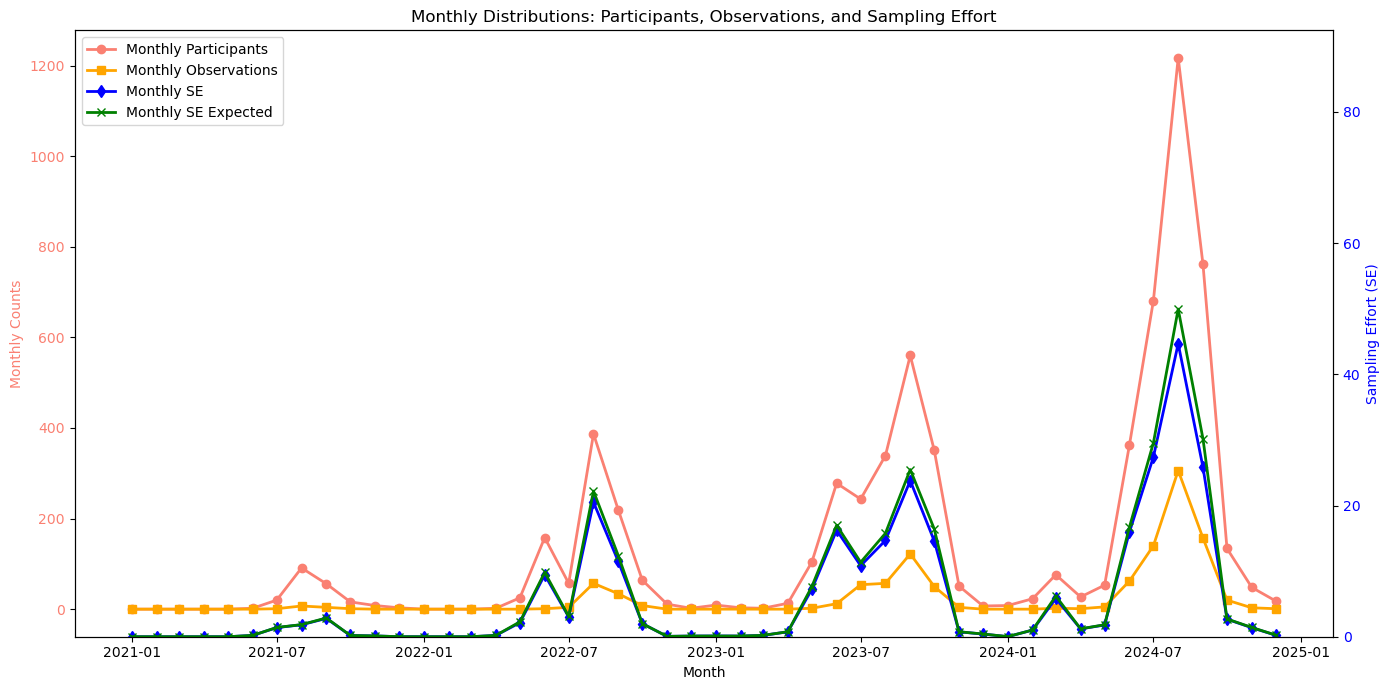

In [35]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# monthly participants on primary y-axis
ax1.plot(monthly_n_participants['year_month'], monthly_n_participants['monthly_n_participants'], 
         color='salmon', marker='o', linewidth=2, label='Monthly Participants')

# monthly counts on primary y-axis
ax1.plot(Albo_monthly_counts['year_month'], Albo_monthly_counts['monthly_counts'], 
         color='orange', marker='s', linewidth=2, label='Monthly Observations')

ax1.set_xlabel('Month')
ax1.set_ylabel('Monthly Counts', color='salmon')
ax1.tick_params(axis='y', labelcolor='salmon')

# secondary y-axis for SE metrics
ax2 = ax1.twinx()  

# monthly sums of SE and SE_expected on secondary y-axis
ax2.plot(monthly_SE['year_month'], monthly_SE['monthly_SE'], 
         color='blue', marker='d', linewidth=2, label='Monthly SE')
ax2.plot(monthly_SE_expected['year_month'], monthly_SE_expected['monthly_SE_expected'],
         color='green', marker='x', linewidth=2, label='Monthly SE Expected')

ax2.set_ylabel('Sampling Effort (SE)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ylim_max = ax2.get_ylim()[1] + 40
ax2.set_ylim(0, ylim_max)  

plt.title('Monthly Distributions: Participants, Observations, and Sampling Effort')
fig.tight_layout()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

# Average SE of each cell over entire period 

In [36]:
#Aggregate SE values by unique cell coordinates over whole time range
SE_aggregated = SE_cropped_complete.groupby(['masked_lat', 'masked_lon']).agg({'SE': 'mean'}).reset_index()
print(SE_aggregated)

    masked_lat  masked_lon        SE
0       47.000      15.325  0.000528
1       47.000      15.350  0.000005
2       47.000      15.375  0.001438
3       47.000      15.400  0.002271
4       47.000      15.425  0.005233
5       47.000      15.450  0.009138
6       47.000      15.475  0.001114
7       47.000      15.500  0.000072
8       47.000      15.525  0.000071
9       47.000      15.550  0.000150
10      47.025      15.350  0.000115
11      47.025      15.375  0.003834
12      47.025      15.400  0.012091
13      47.025      15.425  0.013219
14      47.025      15.450  0.022741
15      47.025      15.475  0.003274
16      47.025      15.500  0.000837
17      47.025      15.525  0.000168
18      47.025      15.550  0.000097
19      47.050      15.325  0.000016
20      47.050      15.350  0.000076
21      47.050      15.375  0.003427
22      47.050      15.400  0.011419
23      47.050      15.425  0.026516
24      47.050      15.450  0.031645
25      47.050      15.475  0.002619
2

## Normalize SE vlaues

In [37]:
min_se = SE_aggregated['SE'].min()
max_se = SE_aggregated['SE'].max()
SE_aggregated['SE_normalized'] = (SE_aggregated['SE'] - min_se) / (max_se - min_se)
print(SE_aggregated['SE_normalized'])

0     0.016514
1     0.000000
2     0.045296
3     0.071616
4     0.165230
5     0.288657
6     0.035051
7     0.002127
8     0.002094
9     0.004582
10    0.003470
11    0.121009
12    0.381975
13    0.417624
14    0.718557
15    0.103321
16    0.026284
17    0.005143
18    0.002893
19    0.000327
20    0.002231
21    0.108150
22    0.360735
23    0.837866
24    1.000000
25    0.082605
26    0.024517
27    0.004238
28    0.007544
29    0.006627
30    0.023562
31    0.299213
32    0.282994
33    0.144199
34    0.038326
35    0.002249
36    0.004238
37    0.026464
38    0.002262
39    0.013658
40    0.054899
41    0.042369
42    0.009480
43    0.028465
44    0.002803
45    0.000036
46    0.002329
47    0.031560
48    0.004385
49    0.002093
50    0.013653
51    0.008416
52    0.002037
53    0.002164
54    0.007841
55    0.004014
Name: SE_normalized, dtype: float64


## Transform df (SE_aggregated) to points to be able to transform it into a Raster in QGIS

In [38]:
SE_aggregated_raster = gpd.GeoDataFrame(
    SE_aggregated, 
    geometry=gpd.points_from_xy(SE_aggregated['masked_lon'], SE_aggregated['masked_lat']),
    crs="EPSG:4326"
)

In [39]:
SE_aggregated_raster.to_file(r'C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\Sampling Effort\SE_cells_total.shp')

C:\Users\Dom\AppData\Local\Temp\ipykernel_24768\3320077902.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SE_aggregated_raster.to_file(r'C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\Sampling Effort\SE_cells_total.shp')
C:\Users\Dom\anaconda3\envs\master\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SE_normalized' to 'SE_normali'
  ogr_write(


# Average SE in August 2022, Septmeber 2023, August 2024

In [41]:
august_2022_data = SE_cropped_complete[
    (SE_cropped_complete['date'] >= '2022-08-01') & 
    (SE_cropped_complete['date'] <= '2022-08-31')
]
september_2023_data = SE_cropped_complete[
    (SE_cropped_complete['date'] >= '2023-09-01') & 
    (SE_cropped_complete['date'] <= '2023-09-30')
]
august_2024_data = SE_cropped_complete[
    (SE_cropped_complete['date'] >= '2024-08-01') & 
    (SE_cropped_complete['date'] <= '2024-08-31')
]

#Aggregate SE values by unique cell coordinates for three different months 
SE_aggregated_0822 = august_2022_data.groupby(['masked_lat', 'masked_lon'])['SE'].mean().reset_index()
SE_aggregated_0923 = september_2023_data.groupby(['masked_lat', 'masked_lon'])['SE'].mean().reset_index()
SE_aggregated_0824 = august_2024_data.groupby(['masked_lat', 'masked_lon'])['SE'].mean().reset_index()

print(SE_aggregated_0824)

    masked_lat  masked_lon        SE
0       47.000      15.325  0.000083
1       47.000      15.350  0.000000
2       47.000      15.375  0.010869
3       47.000      15.400  0.026169
4       47.000      15.425  0.050944
5       47.000      15.450  0.073408
6       47.000      15.475  0.003468
7       47.000      15.500  0.000000
8       47.000      15.525  0.000000
9       47.000      15.550  0.000000
10      47.025      15.350  0.000000
11      47.025      15.375  0.028656
12      47.025      15.400  0.189266
13      47.025      15.425  0.140132
14      47.025      15.450  0.101704
15      47.025      15.475  0.024315
16      47.025      15.500  0.003282
17      47.025      15.525  0.000000
18      47.025      15.550  0.000000
19      47.050      15.325  0.000000
20      47.050      15.350  0.003282
21      47.050      15.375  0.018225
22      47.050      15.400  0.099007
23      47.050      15.425  0.205866
24      47.050      15.450  0.258557
25      47.050      15.475  0.010840
2

# Create Mosquito df for 2022, 2023, 2024, 08.2022, 09.2023, 08.2024 (to map SE and mosquito presences in peak months of the three years)

In [42]:
Albo_graz_gdf.reset_index(inplace=True)
Albo_graz_gdf['creation_date'] = pd.to_datetime(Albo_graz_gdf['creation_date'])

# Create gdf for each year and August 2022, 2024 and September 2023
Albo_2022 = Albo_graz_gdf[Albo_graz_gdf['creation_date'].dt.year == 2022]
Albo_2023 = Albo_graz_gdf[Albo_graz_gdf['creation_date'].dt.year == 2023]
Albo_2024 = Albo_graz_gdf[Albo_graz_gdf['creation_date'].dt.year == 2024]
Albo_august_2022 = Albo_graz_gdf[(Albo_graz_gdf['creation_date'].dt.year == 2022) & 
                                  (Albo_graz_gdf['creation_date'].dt.month == 8)]
Albo_september_2023 = Albo_graz_gdf[(Albo_graz_gdf['creation_date'].dt.year == 2023) & 
                                  (Albo_graz_gdf['creation_date'].dt.month == 9)]
Albo_august_2024 = Albo_graz_gdf[(Albo_graz_gdf['creation_date'].dt.year == 2024) & 
                                  (Albo_graz_gdf['creation_date'].dt.month == 8)]

print(Albo_august_2024)

     creation_date                          version_UUID  \
610     2024-08-04  039de73f-dbb3-4cbb-9845-ad6630d2169f   
613     2024-08-01  13c41b32-f795-4e53-aea7-9f98171d796d   
614     2024-08-04  140f1423-ec16-4200-9bc5-819d50da9947   
615     2024-08-04  1d7f5371-9823-4510-a3e1-3af69678c02b   
616     2024-08-01  1aa546bd-d8cb-4708-9cec-4fba7fb27381   
...            ...                                   ...   
958     2024-08-31  7bc9c5ab-d96e-4325-8e17-19c069494144   
959     2024-08-31  7c3ee1b9-b07b-4335-9bab-814fc2df1473   
981     2024-08-31  e55ceb79-fda9-455f-aed4-32ccab8fe48e   
1111    2024-08-09  423793b2-b392-4e8f-818f-9e790744e228   
1112    2024-08-27  9a2dc760-b714-4ce9-8ed6-8a6828f6f907   

                        creation_time  creation_day_since_launch  \
610  2024-08-04 12:40:23.020498+00:00                       3705   
613  2024-08-01 09:36:29.189827+00:00                       3702   
614  2024-08-04 15:49:24.383299+00:00                       3705   
615  20

In [43]:
min_se, max_se = SE_aggregated_0822['SE'].min(), SE_aggregated_0822['SE'].max()

# Color map based on the min and max SE values
cmap = plt.get_cmap('YlOrRd') 
normalize = mcolors.Normalize(vmin=min_se, vmax=max_se)

m = folium.Map(location=[47.05, 15.45], zoom_start=12)

#SE cells color coded by SE value
for _, row in SE_aggregated_0822.iterrows():
    color = mcolors.to_hex(cmap(normalize(row['SE'])))  
    folium.Rectangle(
        bounds=[
            [row['masked_lat'], row['masked_lon']],
            [row['masked_lat'] + 0.025, row['masked_lon'] + 0.025]
        ],
        color='black', 
        weight=1,  
        fill=True,
        fill_color=color, 
        fill_opacity=0.5,
        popup=f'Sampling Effort: {row["SE"]:.6f}'
    ).add_to(m)

#mosquito sightings
for _, row in Albo_august_2022.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup='Mosquito Sighting'
    ).add_to(m)

title_html = '''
            <h3 align="center" style="font-size:20px"><b>Mosquito Sightings and Sampling Effort in August 2022</b></h3>
            '''
m.get_root().html.add_child(folium.Element(title_html))

legend_html = '''
            <div style="position: fixed; 
                        top: 10px; right: 10px; width: 150px; height: auto; 
                        background-color: white; opacity: .8; z-index:9999;
                        border:2px solid grey; border-radius:5px; padding: 10px;">
            <h4 style="text-align: center;">Sampling Effort (SE)</h4>
            <div style="width: 100%; height: 20px; background: linear-gradient(to right, #ffffcc 0%, #ffcc00 50%, #cc0000 100%);"></div>
            <div style="text-align: center;">0 to {:.2f}</div>
            </div>
            '''.format(max_se)

m.get_root().html.add_child(folium.Element(legend_html))

m

In [44]:
#for comments, see previous plot
min_se, max_se = SE_aggregated_0923['SE'].min(), SE_aggregated_0923['SE'].max()

cmap = plt.get_cmap('YlOrRd')  
normalize = mcolors.Normalize(vmin=min_se, vmax=max_se)

m = folium.Map(location=[47.05, 15.45], zoom_start=12)

for _, row in SE_aggregated_0923.iterrows():
    color = mcolors.to_hex(cmap(normalize(row['SE']))) 
    folium.Rectangle(
        bounds=[
            [row['masked_lat'], row['masked_lon']],
            [row['masked_lat'] + 0.025, row['masked_lon'] + 0.025]  
        ],
        color='black',  
        weight=1,  
        fill=True,
        fill_color=color,  
        fill_opacity=0.5,
        popup=f'Sampling Effort: {row["SE"]:.6f}'
    ).add_to(m)

for _, row in Albo_september_2023.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup='Mosquito Sighting'
    ).add_to(m)

title_html = '''
            <h3 align="center" style="font-size:20px"><b>Mosquito Sightings and Sampling Effort in September 2023</b></h3>
            '''
m.get_root().html.add_child(folium.Element(title_html))

legend_html = '''
            <div style="position: fixed; 
                        top: 10px; right: 10px; width: 150px; height: auto; 
                        background-color: white; opacity: .8; z-index:9999;
                        border:2px solid grey; border-radius:5px; padding: 10px;">
            <h4 style="text-align: center;">Sampling Effort (SE)</h4>
            <div style="width: 100%; height: 20px; background: linear-gradient(to right, #ffffcc 0%, #ffcc00 50%, #cc0000 100%);"></div>
            <div style="text-align: center;">0 to {:.2f}</div>
            </div>
            '''.format(max_se)

m.get_root().html.add_child(folium.Element(legend_html))

m.save('mosquito_sightings_september_2023.html')

m

In [45]:
min_se, max_se = SE_aggregated_0824['SE'].min(), SE_aggregated_0824['SE'].max()

cmap = plt.get_cmap('YlOrRd')  
normalize = mcolors.Normalize(vmin=min_se, vmax=max_se)

m = folium.Map(location=[47.05, 15.45], zoom_start=12)

for _, row in SE_aggregated_0824.iterrows():
    color = mcolors.to_hex(cmap(normalize(row['SE'])))
    folium.Rectangle(
        bounds=[
            [row['masked_lat'], row['masked_lon']],
            [row['masked_lat'] + 0.025, row['masked_lon'] + 0.025]  
        ],
        color='black',  
        weight=1,  
        fill=True,
        fill_color=color,  
        fill_opacity=0.5,
        popup=f'Sampling Effort: {row["SE"]:.6f}'
    ).add_to(m)

for _, row in Albo_august_2024.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup='Mosquito Sighting'
    ).add_to(m)

title_html = '''
            <h3 align="center" style="font-size:20px"><b>Mosquito Sightings and Sampling Effort in August 2024</b></h3>
            '''
m.get_root().html.add_child(folium.Element(title_html))

legend_html = '''
            <div style="position: fixed; 
                        top: 10px; right: 10px; width: 150px; height: auto; 
                        background-color: white; opacity: .8; z-index:9999;
                        border:2px solid grey; border-radius:5px; padding: 10px;">
            <h4 style="text-align: center;">Sampling Effort (SE)</h4>
            <div style="width: 100%; height: 20px; background: linear-gradient(to right, #ffffcc 0%, #ffcc00 50%, #cc0000 100%);"></div>
            <div style="text-align: center;">0 to {:.2f}</div>
            </div>
            '''.format(max_se)

m.get_root().html.add_child(folium.Element(legend_html))

m.save('mosquito_sightings_august_2024.html')

m

In [47]:
# All three years, sightings color coded by year of sampling
min_se, max_se = SE_aggregated['SE'].min(), SE_aggregated['SE'].max()
cmap = plt.get_cmap('YlOrRd')  
normalize = mcolors.Normalize(vmin=min_se, vmax=max_se)

m = folium.Map(location=[47.05, 15.45], zoom_start=12)

for _, row in SE_aggregated.iterrows():
    color = mcolors.to_hex(cmap(normalize(row['SE'])))  
    folium.Rectangle(
        bounds=[
            [row['masked_lat'], row['masked_lon']],
            [row['masked_lat'] + 0.025, row['masked_lon'] + 0.025] 
        ],
        color='black', 
        weight=1,  
        fill=True,
        fill_color=color,  
        fill_opacity=0.5,
        popup=f'Sampling Effort: {row["SE"]:.6f}'
    ).add_to(m)

def get_color(year):
    if year == 2021:
        return 'blue'
    elif year == 2022:
        return 'green'
    elif year == 2023:
        return 'orange'
    elif year == 2024:
        return 'red'
    else:
        return 'gray'  

for _, row in Albo_graz_gdf.iterrows():
    year = row['creation_time'].year
    color = get_color(year)
    
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f'Mosquito Sighting in {year}'
    ).add_to(m)

title_html = '''
            <h3 align="center" style="font-size:20px"><b>Mosquito Sightings and Sampling Effort</b></h3>
            '''
m.get_root().html.add_child(folium.Element(title_html))

legend_html = '''
            <div style="position: fixed; 
                        top: 30px; right: 10px; width: 180px; height: auto; 
                        background-color: white; opacity: .8; z-index:9999;
                        border:2px solid grey; border-radius:5px; padding: 10px;">
            <h4 style="text-align: center;">Sampling Effort (SE)</h4>
            <div style="width: 100%; height: 20px; background: linear-gradient(to right, #ffffcc 0%, #ffcc00 50%, #cc0000 100%);"></div>
            <div style="text-align: center;">0 to {:.2f}</div>
            <h4 style="text-align: center;">Mosquito Sightings</h4>
            <div><span style="color: blue;">&#11044;</span> 2021</div>
            <div><span style="color: green;">&#11044;</span> 2022</div>
            <div><span style="color: orange;">&#11044;</span> 2023</div>
            <div><span style="color: red;">&#11044;</span> 2024</div>
            </div>
            '''.format(max_se)

m.get_root().html.add_child(folium.Element(legend_html))

m.save('mosquito_sightings_with_se.html')

m

# Correlation between Mosquito sightings and SE
### Data preparation of Mosquito Sightings

In [48]:
Albo_graz_gdf['year_month'] = Albo_graz_gdf['creation_time'].dt.to_period('M')

C:\Users\Dom\AppData\Local\Temp\ipykernel_24768\3899151957.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Albo_graz_gdf['year_month'] = Albo_graz_gdf['creation_time'].dt.to_period('M')


### Assign respective SE_cell to each sighting and aggregate sightings for each month and cell 

In [49]:
# function to identify corresponding SE_cell
def get_SE_cell(lat, lon, se_data):
    # Identifiy SE_cell that contains respective mosquito observation
    cell = se_data[(se_data['masked_lat'] <= lat) & 
                   (se_data['masked_lat'] + 0.025 > lat) & 
                   (se_data['masked_lon'] <= lon) & 
                   (se_data['masked_lon'] + 0.025 > lon)]
    
    if not cell.empty:
        return cell[['masked_lat', 'masked_lon']].values[0]
    else:
        return None, None 

# Apply function get_SE_cell to Albo_graz_gdf to assign unique SE_cell coordinates to each observation
Albo_graz_gdf['cell_lat'], Albo_graz_gdf['cell_lon'] = zip(
    *Albo_graz_gdf.apply(lambda row: get_SE_cell(row['lat'], row['lon'], SE_cropped_complete), axis=1)
)

print(Albo_graz_gdf[['lat', 'lon', 'cell_lat', 'cell_lon']])

            lat        lon  cell_lat  cell_lon
0     47.050270  15.448941    47.050    15.425
1     47.049294  15.448477    47.025    15.425
2     47.050837  15.444788    47.050    15.425
3     47.043650  15.453648    47.025    15.450
4     47.048773  15.445369    47.025    15.425
...         ...        ...       ...       ...
1110  47.063500  15.445396    47.050    15.425
1111  47.033247  15.453789    47.025    15.450
1112  47.036647  15.404141    47.025    15.400
1113  47.040126  15.490230    47.025    15.475
1114  47.059083  15.454423    47.050    15.450

[1115 rows x 4 columns]


In [50]:
#aggregate mosquito sightings by year_month and grid cell
Albo_monthly_counts_cell = (
    Albo_graz_gdf.groupby(['year_month', 'cell_lat', 'cell_lon'])
    .size()
    .reset_index(name='count') 
)

print(Albo_monthly_counts_cell)

    year_month  cell_lat  cell_lon  count
0      2021-07    47.050    15.425      1
1      2021-08    47.025    15.425      2
2      2021-08    47.025    15.450      1
3      2021-08    47.050    15.425      3
4      2021-08    47.050    15.450      1
..         ...       ...       ...    ...
148    2024-10    47.100    15.375      1
149    2024-11    47.000    15.400      1
150    2024-11    47.050    15.450      1
151    2024-11    47.075    15.400      1
152    2024-12    47.100    15.450      1

[153 rows x 4 columns]


### Calcualte average SE for each cell and month

In [53]:
SE_monthly_cell_average = (
    SE_cropped_complete.groupby(['masked_lat', 'masked_lon', 'year_month'])['SE']
    .mean()
    .reset_index()
)

SE_monthly_cell_average.columns = ['cell_lat', 'cell_lon', 'year_month', 'average_SE']

print(SE_monthly_cell_average.head(5))

   cell_lat  cell_lon year_month  average_SE
0      47.0    15.325    2021-01         0.0
1      47.0    15.325    2021-02         0.0
2      47.0    15.325    2021-03         0.0
3      47.0    15.325    2021-04         0.0
4      47.0    15.325    2021-05         0.0


In [52]:
#delete entries with average_SE==0
SE_monthly_cell_average_2 = SE_monthly_cell_average[SE_monthly_cell_average['average_SE'] != 0]
print (SE_monthly_cell_average_2)

      cell_lat  cell_lon year_month  average_SE
6       47.000    15.325    2021-07    0.008733
7       47.000    15.325    2021-08    0.003779
8       47.000    15.325    2021-09    0.000515
9       47.000    15.325    2021-10    0.000191
10      47.000    15.325    2021-11    0.000258
...        ...       ...        ...         ...
2625    47.125    15.500    2023-10    0.005291
2628    47.125    15.500    2024-01    0.000080
2633    47.125    15.500    2024-06    0.006438
2634    47.125    15.500    2024-07    0.000336
2668    47.125    15.525    2023-05    0.006230

[618 rows x 4 columns]


### Add missing entries to Albo_monthly_counts_cell for each lat/lon and YearMonth combination in SE_monthly_cell_average
### --> Cells with SE but no observations

In [54]:
# DF with all combinations from SE_monthly_cell_average_2
all_combinations = (
    SE_monthly_cell_average_2[['year_month', 'cell_lat', 'cell_lon']]
)

#merge with Albo_monthly_counts_cell to identify missing combinations
# Outer join keeps all entries from both dfs. When a row doesn't share information with a row from the other df, it is filled with NaN 
# Indicator true adds an attribute to merged_df called "_merged". 
merged_df = pd.merge(all_combinations, Albo_monthly_counts_cell, on=['year_month', 'cell_lat', 'cell_lon'], how='outer', indicator=True)

#Missing entries are identified by "left_only" and a count of 0 is assigned. --> No sightings on that day and cell
missing_entries = merged_df[merged_df['_merge'] == 'left_only'][['year_month', 'cell_lat', 'cell_lon']]
missing_entries['count'] = 0

#combine missing_entries with existing counts 
Albo_monthly_counts_cell = pd.concat([Albo_monthly_counts_cell, missing_entries], ignore_index=True)

# Sort for readability
Albo_monthly_counts_cell.sort_values(by=['year_month', 'cell_lat', 'cell_lon'], inplace=True)

print(Albo_monthly_counts_cell)

    year_month  cell_lat  cell_lon  count
153    2021-06    47.075    15.400      0
154    2021-06    47.075    15.425      0
155    2021-07    47.000    15.325      0
156    2021-07    47.000    15.400      0
157    2021-07    47.025    15.350      0
..         ...       ...       ...    ...
614    2024-12    47.050    15.475      0
615    2024-12    47.075    15.400      0
616    2024-12    47.075    15.425      0
617    2024-12    47.075    15.450      0
152    2024-12    47.100    15.450      1

[618 rows x 4 columns]


### Merge Albo_monthly_counts_cell and SE_monthly_cell_average_2

In [55]:
#Add SE value to Albo_monthly_counts_cell
Albo_monthly_counts_cell = pd.merge(
    Albo_monthly_counts_cell, 
    SE_monthly_cell_average_2[['cell_lat', 'cell_lon', 'year_month', 'average_SE']], 
    on=['year_month', 'cell_lat', 'cell_lon'], 
    how='left'  #left join to keep all entries in Albo_monthly_counts_cell
)

print(Albo_monthly_counts_cell)

    year_month  cell_lat  cell_lon  count  average_SE
0      2021-06    47.075    15.400      0    0.003391
1      2021-06    47.075    15.425      0    0.003391
2      2021-07    47.000    15.325      0    0.008733
3      2021-07    47.000    15.400      0    0.003282
4      2021-07    47.025    15.350      0    0.003282
..         ...       ...       ...    ...         ...
613    2024-12    47.050    15.475      0    0.000225
614    2024-12    47.075    15.400      0    0.000039
615    2024-12    47.075    15.425      0    0.000079
616    2024-12    47.075    15.450      0    0.000086
617    2024-12    47.100    15.450      1    0.006230

[618 rows x 5 columns]


In [56]:
#Drop NaN for linear regression
Albo_monthly_counts_cell=Albo_monthly_counts_cell.dropna(subset=['count', 'average_SE'])

### Linear regression of Albo_monthly_counts_cell and SE_monthly_cell_average

In [57]:
y = Albo_monthly_counts_cell['count']  
X = Albo_monthly_counts_cell[['average_SE']]  

# create linear regression model
model = LinearRegression()

#model fitting 
model.fit(X, y)

#model parameters
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X, y)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")

Slope: 190.14527425024633
Intercept: -0.9442005486966207
R-squared: 0.790004186180565


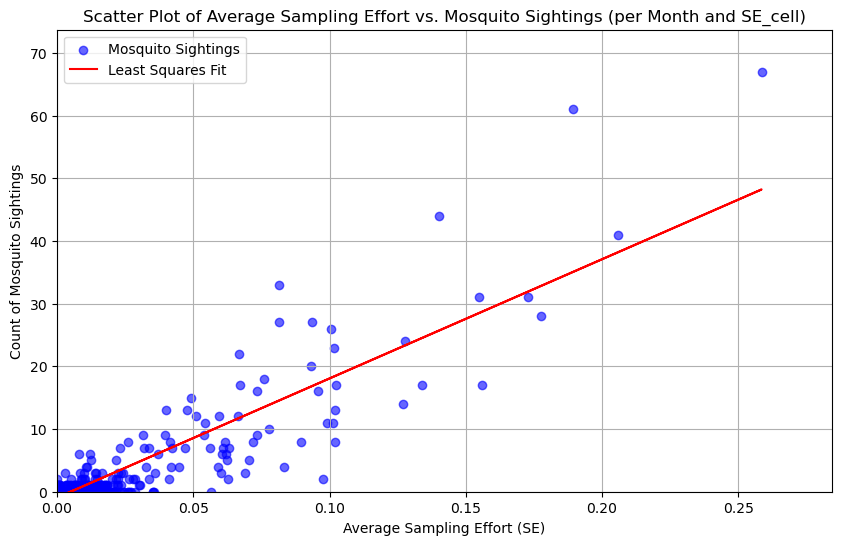

In [58]:
plt.figure(figsize=(10, 6))

plt.scatter(Albo_monthly_counts_cell['average_SE'], Albo_monthly_counts_cell['count'], alpha=0.6, color='blue', label='Mosquito Sightings')

#calculate line of linear regression
fit_line = slope * Albo_monthly_counts_cell['average_SE'] + intercept

plt.plot(Albo_monthly_counts_cell['average_SE'], fit_line, color='red', label='Least Squares Fit')

plt.title('Scatter Plot of Average Sampling Effort vs. Mosquito Sightings (per Month and SE_cell)')
plt.xlabel('Average Sampling Effort (SE)')
plt.ylabel('Count of Mosquito Sightings')
plt.legend()
plt.grid()
plt.xlim(0, Albo_monthly_counts_cell['average_SE'].max() * 1.1)  
plt.ylim(0, Albo_monthly_counts_cell['count'].max() * 1.1) 
plt.savefig(r'C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Figures\Corr_Mos_SE.png', dpi=300, bbox_inches='tight')
plt.show()



## Export validated presences to csv for QGIS

In [ ]:
Albo_val1.to_csv(r'C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\Albo_val1.csv', index=False)
Albo_val2.to_csv(r'C:\Users\Dom\Documents\Studium\Master\Mein_Studium\Masterarbeit\Jupyter\Data\MosquitoAlert\Albo_val2.csv', index=False)

In [ ]:
print(Albo_graz_gdf)